## Fully-connected Network

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, models
import matplotlib.pyplot as plt

In [62]:
(x, y), (t_x, t_y) = datasets.mnist.load_data()
print("X.shape", x.shape)
print("testX.shape", test_x.shape)
print("Y.len", len(y))

X.shape (60000, 28, 28)
testX.shape (10000, 28, 28)
Y.len 60000


In [3]:
#del mnist_dataset
def mnist_dataset():
    (train_x, train_y), (test_x, test_y) = datasets.mnist.load_data()
    ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    ds = ds.map(prepare_mnist_features_and_labels)
    ds = ds.take(20000).shuffle(20000).batch(100)
    # 20000 // 100 = 200 steps
    return ds
def prepare_mnist_features_and_labels(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.int64)
    return x, y

In [6]:
#del model
def create_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(28*28,),name="inputs"))
    model.add(layers.Reshape(target_shape=(28*28,),name="reshape"))
    model.add(layers.Dense(units=100, activation="relu",name="hidden_1"))
    model.add(layers.Dense(units=10, activation="softmax",name="outputs"))
    model.summary()
    return model

model = create_model()
optimizer = optimizers.Adam()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               78500     
_________________________________________________________________
outputs (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [8]:

@tf.function
def compute_loss(logits, labels):
    return tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=labels))

@tf.function
def compute_accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))

@tf.function
def train_one_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss = compute_loss(logits, y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    accuracy = compute_accuracy(logits, y)
    
    return loss, accuracy

def train(epoch, model, optimizer):
    train_ds = mnist_dataset()
    loss = 0.0
    accuracy = 0.0
    total_step = 0
    for step, (x, y) in enumerate(train_ds):
        total_step  += 1
        loss, accuracy = train_one_step(model, optimizer, x, y)
        if (step+1) % 100 == 0:
            print('epoch', epoch,"step",(step+1), ': loss', loss.numpy(), '; accuracy', accuracy.numpy())
    print("total_step",total_step)
    return loss, accuracy

for epoch in range(3):
    loss, accuracy = train(epoch, model, optimizer)

print('Final epoch', epoch, ': loss', loss.numpy(), '; accuracy', accuracy.numpy())
    

epoch 0 step 100 : loss 1.5489132 ; accuracy 0.92
epoch 0 step 200 : loss 1.53336 ; accuracy 0.94
total_step 200
epoch 1 step 100 : loss 1.5554122 ; accuracy 0.91
epoch 1 step 200 : loss 1.4802616 ; accuracy 0.99
total_step 200
epoch 2 step 100 : loss 1.4994601 ; accuracy 0.97
epoch 2 step 200 : loss 1.5153672 ; accuracy 0.97
total_step 200
Final epoch 2 : loss 1.5153672 ; accuracy 0.97


In [57]:
a = model.get_layer(index=0)
print(a)
print(a.name)
b =  model.get_layer(index=-1)
print(b)
print(b.name)
#print(b.weights)
#print(b.get_weights())
c =  model.get_layer(name="hidden_1")
print(c)
print(c.name)
print("input_shape:\t",c.input_shape)
print("weights:\t",c.variables[0].shape)
print("bias:\t\t",c.variables[1].shape)
print("output_shape:\t",c.output_shape)
#print(dir(c))
#print(c.bias)
#model.get_config()

reshape
outputs
hidden_1
input_shape:	 (None, 784)
weights:	 (784, 100)
bias:		 (100,)
output_shape:	 (None, 100)


predictions:7210414969
labels:	    7210414959

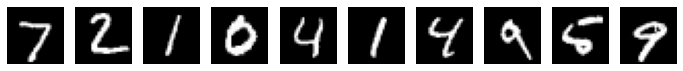

In [75]:
predictions = model.predict(t_x[0:10].reshape((10,28*28)))
print("predictions:",end="")
for predict in predictions:
    print(predict.argmax(axis=0),end="")
print()
print("labels:\t    ",end="")
for label in t_y[0:10]:
    print(label,end="")
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.imshow(t_x[i], cmap="gray")
    plt.axis("off")
plt.show()

## Convolutional Network

In [76]:
import os, time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers, metrics
import matplotlib.pyplot as plt
from tensorflow.python.ops import summary_ops_v2

In [79]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
# del mnist_dataset
def mnist_dataset():
    (x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
    print("x_train.shape",x_train.shape)
    print("x_test.shape",x_test.shape)
    print("y_train.len",len(y_train))
    x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0
    y_train, y_test = y_train.astype(np.int64), y_test.astype(np.int64)
    train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))
    return train_ds, test_ds

In [80]:
train_ds, test_ds = mnist_dataset()
train_ds = train_ds.shuffle(60000).batch(100)
test_ds = test_ds.batch(100)

x_train.shape (60000, 28, 28)
x_test.shape (10000, 28, 28)
y_train.len 60000


In [81]:
#del model
#del optimizer
def create_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(28,28),name="inputs"))
    model.add(layers.Reshape(target_shape=(28,28,1), name="reshape_1"))
    model.add(layers.Conv2D(filters=2, kernel_size=5, padding="same", activation="relu", name="conv2d_1"))
    model.add(layers.MaxPooling2D(pool_size=(5,5), strides=(2,2), padding="same", name="pool2d_1"))
    model.add(layers.Conv2D(filters=4, kernel_size=5, padding="same", activation="relu", name="conv2d_2"))
    model.add(layers.MaxPooling2D(pool_size=(5,5), strides=(2,2), padding="same", name="pool2d_2"))
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(units=32, activation="relu", name="hidden_1"))
    model.add(layers.Dropout(rate=0.3, name="dropout_1"))
    model.add(layers.Dense(units=10, activation="softmax", name="outputs"))

    model.summary()
    return model
model = create_model()
optimizer = optimizers.SGD(learning_rate=0.05, momentum=0.5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 2)         52        
_________________________________________________________________
pool2d_1 (MaxPooling2D)      (None, 14, 14, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 4)         204       
_________________________________________________________________
pool2d_2 (MaxPooling2D)      (None, 7, 7, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 32)               

In [82]:
compute_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
compute_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

def train_step(model, optimizrer, images, labels):
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss = compute_loss(labels, logits)
        compute_accuracy(labels, logits)
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def train(model, optimizer, dataset, log_freq=100):    
    avg_loss = metrics.Mean("loss", dtype=tf.float32)
    for images, labels in dataset:
        loss = train_step(model, optimizer, images, labels)
        avg_loss(loss)
        
        if tf.equal(optimizer.iterations % log_freq, 0):
            print("step:", int(optimizer.iterations),
                  "loss:", avg_loss.result().numpy(),
                  "acc:", compute_accuracy.result().numpy())
            avg_loss.reset_states()
            compute_accuracy.reset_states()
            
def test(model, dataset, step_num):
    avg_loss = metrics.Mean("loss", dtype=tf.float32)
    for (images, labels) in dataset:
        logits = model(images, training=False)
        avg_loss(compute_loss(labels, logits))
        compute_accuracy(labels, logits)
        
    print('Model test set loss: {:0.4f} accuracy: {:0.2f}%'.format(
        avg_loss.result(), compute_accuracy.result() * 100))
    print('loss:', avg_loss.result(), 'acc:', compute_accuracy.result())
    summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
    summary_ops_v2.scalar('accuracy', compute_accuracy.result(), step=step_num)
        

In [83]:
MODEL_DIR = './tmp/tensorflow/mnist/'
def apply_clean():
    if tf.io.gfile.exists(MODEL_DIR):
        print('Removing existing model dir: {}'.format(MODEL_DIR))
        tf.io.gfile.rmtree(MODEL_DIR)
apply_clean()

checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
print(checkpoint_dir)
os.makedirs(checkpoint_dir,exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Removing existing model dir: ./tmp/tensorflow/mnist/
./tmp/tensorflow/mnist/checkpoints
./tmp/tensorflow/mnist/checkpoints\ckpt


In [84]:
NUM_TRAIN_EPOCHS = 5

for i in range(NUM_TRAIN_EPOCHS):
    start = time.time()
    #   with train_summary_writer.as_default():
    train(model, optimizer, train_ds, log_freq=500)
    end = time.time()
    print('Train time for epoch #{} ({:,} total steps): {:.2f} secs'.format(
        i + 1, int(optimizer.iterations), end - start))
    #   with test_summary_writer.as_default():
    #     test(model, test_ds, optimizer.iterations)
    checkpoint.save(checkpoint_prefix)
    print('saved checkpoint.')

export_path = os.path.join(MODEL_DIR, 'export/')
os.makedirs(export_path, exist_ok=True)
tf.saved_model.save(model, export_path)
print('saved SavedModel for exporting.')

step: 500 loss: 1.967454 acc: 0.4969
Train time for epoch #1 (600 total steps): 20.13 secs
saved checkpoint.
step: 1000 loss: 1.654776 acc: 0.80656
Train time for epoch #2 (1,200 total steps): 20.38 secs
saved checkpoint.
step: 1500 loss: 1.6340073 acc: 0.82526
Train time for epoch #3 (1,800 total steps): 20.68 secs
saved checkpoint.
step: 2000 loss: 1.6209575 acc: 0.83722
Train time for epoch #4 (2,400 total steps): 20.77 secs
saved checkpoint.
step: 2500 loss: 1.620119 acc: 0.83996
step: 3000 loss: 1.6172566 acc: 0.84492
Train time for epoch #5 (3,000 total steps): 21.40 secs
saved checkpoint.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./tmp/tensorflow/mnist/export/assets
saved SavedModel for exporting.


predictions:7210414457
labels:	    7210414959

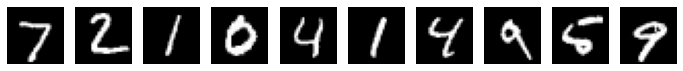

In [85]:
predictions = model.predict(x_test[0:10])
print("predictions:",end="")
for predict in predictions:
    print(predict.argmax(axis=0),end="")
print()
print("labels:\t    ",end="")
for label in y_test[0:10]:
    print(label,end="")
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.imshow(x_test[i], cmap="gray")
    plt.axis("off")
plt.show()